In [1]:
import numpy as np
import matplotlib.pyplot as plt
from synthetic import TestSuite

In [2]:
def RMSE_Loss(actual, predicted):
    """Root Mean Squared Error"""
    return np.sqrt(np.mean(np.square(actual - predicted)))

In [3]:
def min_max_transform(series):
  series_temp = np.copy(series)
  for i in range(len(series_temp)):
    series_temp[i] = (series_temp[i] - np.max(series))/(np.max(series)-np.min(series)) + 1
  return series_temp

In [4]:
import os, shutil
DIR="experiment_rbf_svr/"
FILE_NAME=DIR+"/log.csv"
if os.path.exists(DIR): shutil.rmtree(DIR)
if not os.path.exists(DIR): os.mkdir(DIR)

In [5]:
def outputExperiment(id, series_name, mixed, feature_length, target_length, target_offset, rmse_train, rmse_test, c, epsilon, gamma):
    with open(FILE_NAME, 'a') as f:
        result = ", ".join(map(str, list([id, series_name , mixed , feature_length , target_length , target_offset , rmse_train , rmse_test, c, epsilon, gamma])))
        print(result, file=f)

In [6]:
def showExperiment(ID, mixed, series, series_name, Y_train, Y_test, Yhat_train, Yhat_test, Yhat_series, rmse_train, rmse_test):
    plt.figure(figsize=(30,10))
    plt.subplot(311)
    plt.margins(0.05)
    plt.plot(series)
    plt.plot(Yhat_series)
    plt.legend(["True", "Predicted"])
    plt.title("Series: "+ series_name+" (Random Sampling="+str(mixed)+")")

    plt.subplot(323)
    plt.margins(0.05)
    plt.plot(Y_train)
    plt.plot(Yhat_train)
    plt.legend(["True", "Predicted"])
    plt.title("RMSE Train: "+ str(rmse_train))

    plt.subplot(324)
    plt.margins(0.05)
    plt.plot(Y_test)
    plt.plot(Yhat_test)
    plt.legend(["True", "Predicted"])
    plt.title("RMSE Test: "+ str(rmse_test))

    plt.subplot(325)
    plt.margins(0.05)
    plt.plot(abs(Y_train - Yhat_train))
    plt.legend(["Residuals"])
    plt.title("Train")

    plt.subplot(326)
    plt.margins(0.05)
    plt.plot(abs(Y_test - Yhat_test))
    plt.legend(["Residuals"])
    plt.title("Test")

    plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
    plt.savefig(DIR+str(ID)+".png", transparent=True)

# Radial Basis Function SVR

In [7]:
from src.models.regressor.svr import Model_RBF_SVR

In [8]:
def executeRadialBasisFunctionSVR(X_train, X_test, Y_train, Y_test):
    model_rbf_svr = Model_RBF_SVR(error_fun=RMSE_Loss)
    yhat_train = model_rbf_svr.__train__(X_train=X_train, Y_train=Y_train)
    rmse_train = model_rbf_svr.__get_error_train__()

    yhat_test = model_rbf_svr.__test__(X_test=X_test, Y_test=Y_test)
    rmse_test = model_rbf_svr.__get_error_test__()

    yhat_series = model_rbf_svr.__test__(X_test=np.concatenate((X_train, X_test), axis=0), Y_test=np.concatenate((Y_train, Y_test), axis=0))

    c_param = model_rbf_svr.__get_model__().C
    epsilon_param = model_rbf_svr.__get_model__().epsilon
    gamma_param = model_rbf_svr.__get_model__().gamma
    return rmse_train, rmse_test, yhat_train, yhat_test, yhat_series, c_param, epsilon_param, gamma_param

In [9]:
def PipelineRadialBasisFunctionSVR():
    synthetic_dataset_test_suite = TestSuite()

    synthetic_datasets =  synthetic_dataset_test_suite.__get_test_suite_size__()
    
    mixed = [True, False]
    feature_length = [1, 2, 3, 4, 5]
    target_offset = [1, 2, 3, 4, 5]
    target_length = [1]

    ID = 0
    print("\t{}\t{}\t{}\t{}\t{}\t{}\t{}".format("ID", "Series", "Mixed", "Autoregressive Variables", "Target Length", "Target Offset", "RMSE Train", "RMSE Test", "PARAM: C", "PARAM: EPSILON", "PARAM: GAMMA"))
    for index in range(synthetic_datasets):
        series = synthetic_dataset_test_suite.__get_numpy_test_series_from_index__(index)
        for ind_mixed in mixed:
            for ind_feature in feature_length:
                for ind_offset in target_offset:
                    for ind_target in target_length:
                        X_train, X_test, Y_train, Y_test = synthetic_dataset_test_suite.__train_and_test_from_numpy_series__(
                            transform=min_max_transform,
                            series=series,
                            mixed=ind_mixed,
                            feature_length=ind_feature,
                            offset=ind_offset,
                            target_length=ind_target,
                            tensor = False
                        )
                        Y_train, Y_test = Y_train.flatten(), Y_test.flatten()
                        rmse_train, rmse_test, yhat_train, yhat_test, yhat_series, c_param, epsilon_param, gamma_param = executeRadialBasisFunctionSVR(X_train=X_train, X_test=X_test, Y_train=Y_train, Y_test=Y_test)
                        outputExperiment(
                            ID,
                            synthetic_dataset_test_suite.__get_name_test_series_from_index__(index),
                            ind_mixed,
                            ind_feature,
                            ind_offset,
                            ind_target,
                            rmse_train,
                            rmse_test,
                            c_param,
                            epsilon_param,
                            gamma_param,
                        )
                        showExperiment(
                            ID,
                            ind_mixed,
                            np.concatenate((Y_train, Y_test), axis=0),
                            synthetic_dataset_test_suite.__get_name_test_series_from_index__(index),
                            Y_train,
                            Y_test,
                            yhat_train,
                            yhat_test,
                            yhat_series,
                            rmse_train,
                            rmse_test
                        )
                        ID += 1
    

In [10]:
# PipelineRadialBasisFunctionSVR()

In [11]:
from cross_validation.regressor import KFoldCrossValidation_RBF_SVR

In [12]:

synthetic_dataset_test_suite = TestSuite()
cv_rbf_svr_regression = KFoldCrossValidation_RBF_SVR(
    series = synthetic_dataset_test_suite.__get_numpy_test_series_from_index__(6),
    loss = RMSE_Loss,
    one_step_offset_target= 1
)

# 'C': [0.05, 0.1, 1, 2, 4, 8, 10],
# 'epsilon': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1],
# 'gamma': [1e-4, 1e-3, 1e-2, 1e-1, 1, 5]
cross_validation_param = {
    "features_length": np.arange(1, 5, 1).tolist(),
    'C': [100],
    'epsilon': [1e-6, 1e-1],
    'gamma': [1e-4, 1e-2]
}
params, model = cv_rbf_svr_regression.search(cross_validation_param)

[0.03274468705058098, 0.0018097078764655599, {'features_length': 1, 'C': 100, 'epsilon': 1e-06, 'gamma': 0.0001}, <models.regressor.svr.Model_RBF_SVR object at 0x000002BA76615F40>]
[0.03230669032782316, 0.001428418573555828, {'features_length': 1, 'C': 100, 'epsilon': 1e-06, 'gamma': 0.01}, <models.regressor.svr.Model_RBF_SVR object at 0x000002BA76615B80>]
[0.06661282442510127, 0.002642234433190864, {'features_length': 1, 'C': 100, 'epsilon': 0.1, 'gamma': 0.0001}, <models.regressor.svr.Model_RBF_SVR object at 0x000002BA76615FD0>]
[0.0547556921839714, 0.0016904029837311034, {'features_length': 1, 'C': 100, 'epsilon': 0.1, 'gamma': 0.01}, <models.regressor.svr.Model_RBF_SVR object at 0x000002BA6DA46C70>]
[0.03981383666396141, 0.002732114813500802, {'features_length': 2, 'C': 100, 'epsilon': 1e-06, 'gamma': 0.0001}, <models.regressor.svr.Model_RBF_SVR object at 0x000002BA76621C40>]
[0.005404212884604931, 0.0004568477234028645, {'features_length': 2, 'C': 100, 'epsilon': 1e-06, 'gamma': 0

In [13]:
params

{'features_length': 4, 'C': 100, 'epsilon': 1e-06, 'gamma': 0.01}

In [14]:
model

In [15]:
_, X_test, _, Y_test = synthetic_dataset_test_suite.__train_and_test_from_numpy_series__(
    transform=min_max_transform,
    series=synthetic_dataset_test_suite.__get_numpy_test_series_from_index__(6),
    mixed=False,
    feature_length=params["features_length"],
    offset=1,
    target_length=1
)

In [16]:
yhat = model.__test__(X_test, Y_test)

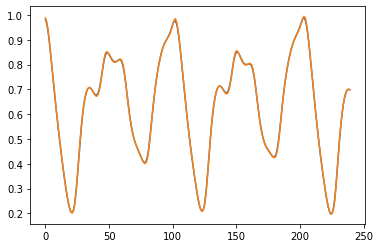

In [17]:
plt.plot(Y_test)
plt.plot(yhat)